In [0]:
!nvidia-smi

Tue Jun  9 11:14:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [26]:
!pip install -q -U watermark
!pip install -qq transformers
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.0.4
torch 1.5.0+cu101
transformers 2.11.0


In [0]:
import transformers
from transformers import RobertaModel, RobertaTokenizer,RobertaForMultipleChoice, AdamW, get_linear_schedule_with_warmup, RobertaConfig
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [28]:
!wget -O data.csv https://raw.githubusercontent.com/tushar1210/Emotional-Anlaysis-BERT/master/data.csv?token=AFCBJT34JSHQNFD7PXM73HS65CVMO

--2020-06-15 07:41:32--  https://raw.githubusercontent.com/tushar1210/Emotional-Anlaysis-BERT/master/data.csv?token=AFCBJT34JSHQNFD7PXM73HS65CVMO
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977654 (955K) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>] 954.74K  --.-KB/s    in 0.06s   

2020-06-15 07:41:32 (15.6 MB/s) - ‘data.csv’ saved [977654/977654]



In [0]:
df = pd.read_csv('data.csv')

In [0]:
df = df.drop('Unnamed: 0', 1)

In [0]:
enc_classes={'joy':0,'fear':1,'anger':2,'sadness':3,'digust':2,'shame':3,'guilty':3}
class_name=['joy','fear','anger','sadness']

def to_number(emotion):
  emotion=str(emotion)
  return enc_classes[emotion]

df['Enc_Emotion'] = df.Emotion.apply(to_number)



In [0]:
df=df.drop('Emotion',1)
df[:8]

,Sentence,Enc_Emotion
0,"During the period of falling in love, each tim...",0
1,When I was involved in a traffic accident.,1
2,When I was driving home after several days of...,2
3,When I lost the person who meant the most to me.,3
4,The time I knocked a deer down - the sight of ...,2
5,When I did not speak the truth.,3
6,When I caused problems for somebody because he...,3
7,When I got a letter offering me the Summer job...,0


In [0]:
df.shape

(7666, 2)

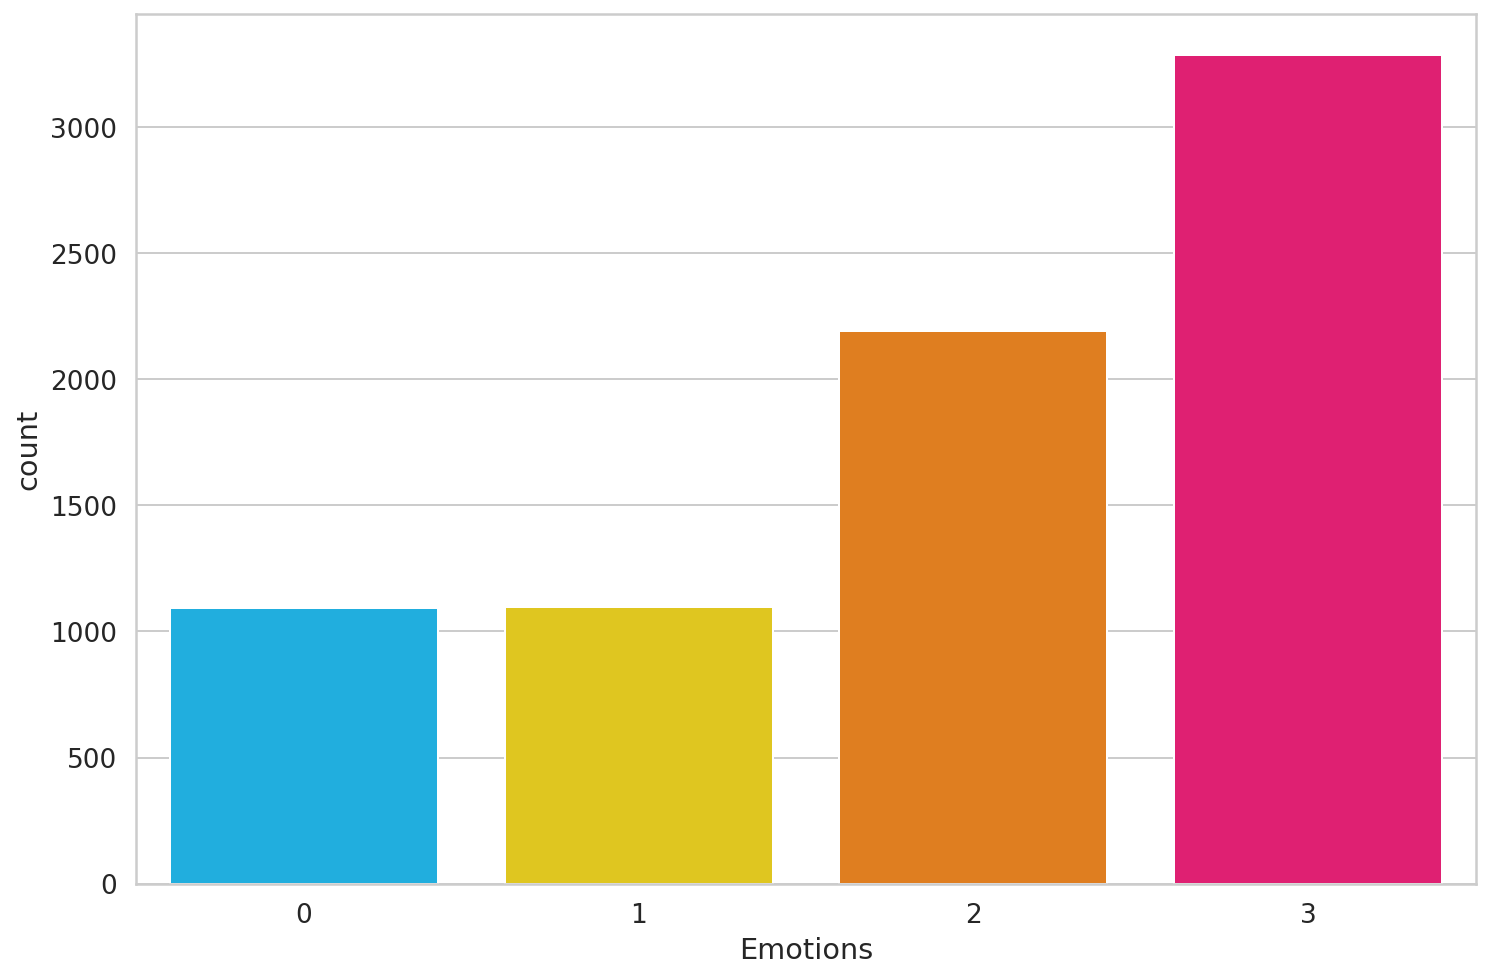

In [0]:
sns.countplot(df.Enc_Emotion)
plt.xlabel('Emotions');

In [0]:
PRE_TRAINED_MODEL_NAME = 'roberta-base'

In [0]:
tokenizer = RobertaTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [0]:
tokenizer.sep_token, tokenizer.sep_token_id

('</s>', 2)

In [0]:
configuration = RobertaConfig()

In [0]:
model = RobertaModel(configuration)

In [0]:
#CLS TOKEN : we must add this token to the start of each sentence, so BERT knows we're doing classification
tokenizer.cls_token, tokenizer.cls_token_id

('<s>', 0)

In [0]:
#PAD Token: for padding
tokenizer.pad_token, tokenizer.pad_token_id

('<pad>', 1)

In [0]:
tokenizer.unk_token, tokenizer.unk_token_id

('<unk>', 3)

In [0]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [0]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([   0,  520,   21,   38,   94,  751,  116,   38,  524, 4889,   23,  184,
          13,  132,  688,    4,    2,    1,    1,    1,    1,    1,    1,    1,
           1,    1,    1,    1,    1,    1,    1,    1])

In [0]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['<s>',
 'ĠWhen',
 'Ġwas',
 'ĠI',
 'Ġlast',
 'Ġoutside',
 '?',
 'ĠI',
 'Ġam',
 'Ġstuck',
 'Ġat',
 'Ġhome',
 'Ġfor',
 'Ġ2',
 'Ġweeks',
 '.',
 '</s>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>',
 '<pad>']

In [0]:
token_lens = []

for txt in df.Sentence:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

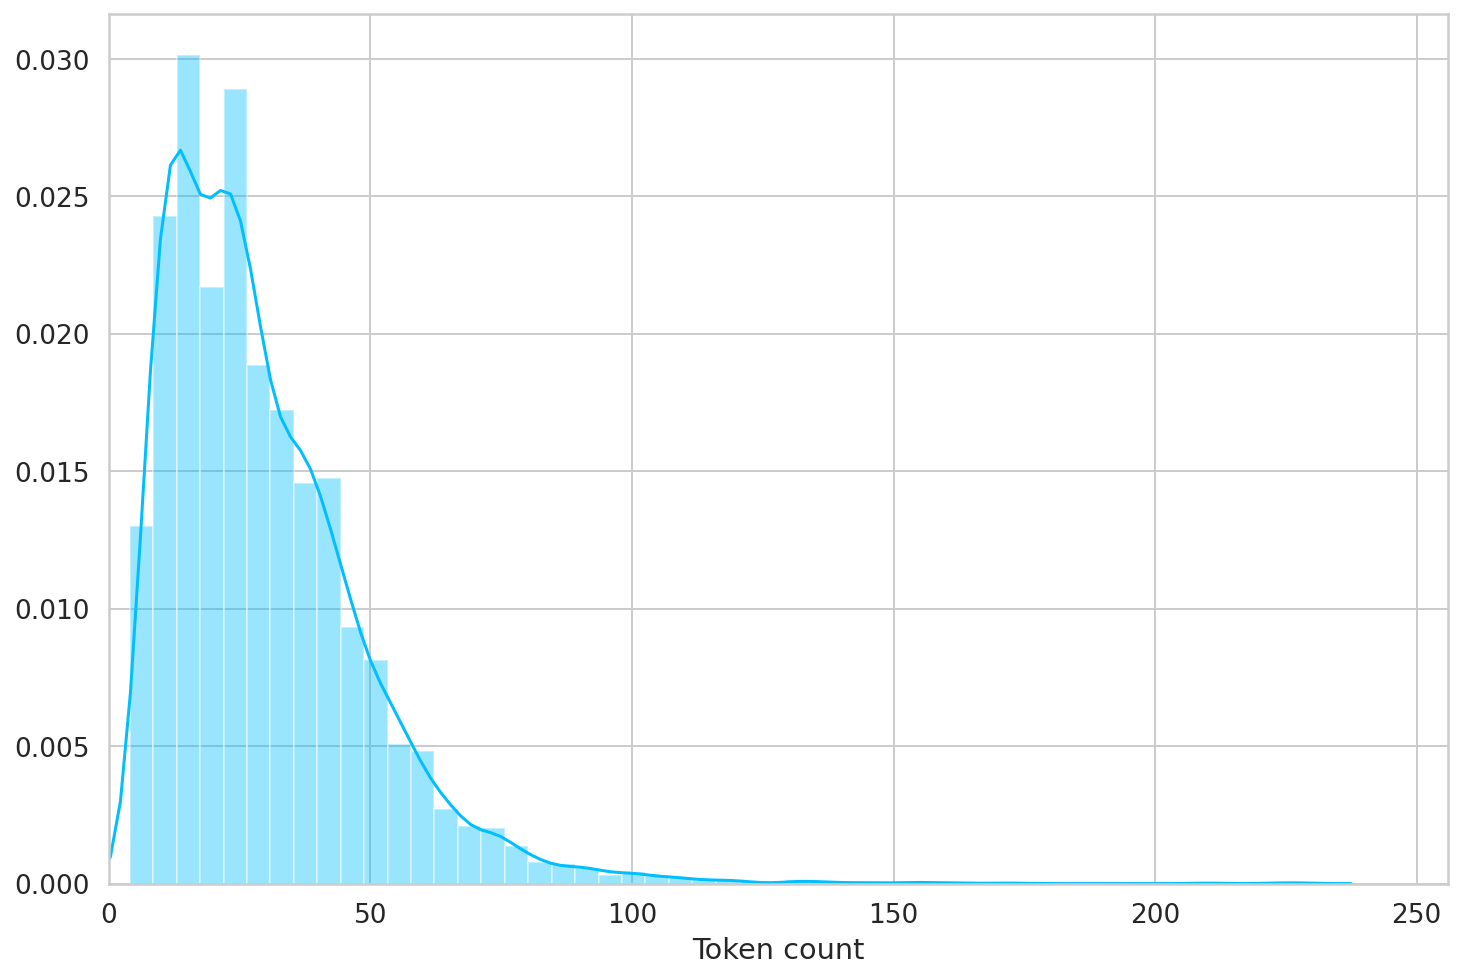

In [0]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [0]:
MAX_LEN = 130

In [0]:
class EmotionReviewDataSet(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [0]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)


In [0]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = EmotionReviewDataSet(
    reviews=df.Sentence.to_numpy(),
    targets=df.Enc_Emotion.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [0]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [0]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [0]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 130])
torch.Size([16, 130])
torch.Size([16])


In [0]:
bert_model = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [0]:

last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [0]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [0]:
bert_model.config.hidden_size

768

In [0]:
pooled_output.shape

torch.Size([1, 768])

In [0]:
class EmotionClassifier(nn.Module):

  def __init__(self, n_classes):
    super(EmotionClassifier, self).__init__()
    self.bert = RobertaModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [0]:
torch.cuda.empty_cache()

In [0]:
model = EmotionClassifier(len(class_name))
model = model.to(device)

In [0]:
type(model)

__main__.EmotionClassifier

In [0]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 130])
torch.Size([16, 130])


In [0]:
import torch.nn.functional as F
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3003, 0.2207, 0.2565, 0.2225],
        [0.2671, 0.2120, 0.2232, 0.2977],
        [0.2872, 0.2261, 0.2616, 0.2252],
        [0.2582, 0.2724, 0.2441, 0.2253],
        [0.2650, 0.2425, 0.2310, 0.2615],
        [0.2695, 0.2219, 0.2549, 0.2537],
        [0.2628, 0.2151, 0.2306, 0.2916],
        [0.2817, 0.2210, 0.2460, 0.2513],
        [0.2859, 0.2444, 0.2441, 0.2257],
        [0.2573, 0.2361, 0.2769, 0.2297],
        [0.2867, 0.2372, 0.2242, 0.2519],
        [0.3125, 0.2338, 0.2317, 0.2220],
        [0.2747, 0.2523, 0.2525, 0.2206],
        [0.3023, 0.2265, 0.2294, 0.2418],
        [0.2593, 0.2352, 0.2172, 0.2883],
        [0.2879, 0.2298, 0.2426, 0.2398]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [0]:
EPOCHS = 20

optimizer = AdamW(model.parameters(), lr=2e-6, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [0]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [0]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [0]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

In [0]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [0]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

In [0]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [0]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [0]:
print(classification_report(y_test, y_pred, target_names=class_name))

In [0]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)

In [0]:
!wget -O test.csv https://raw.githubusercontent.com/tushar1210/Emotional-Anlaysis-BERT/master/airbnb_dataset.csv?token=AFCBJT25ULC2LEKXARBP4PS65CS7Q

--2020-06-09 11:23:41--  https://raw.githubusercontent.com/tushar1210/Emotional-Anlaysis-BERT/master/airbnb_dataset.csv?token=AFCBJT25ULC2LEKXARBP4PS65CS7Q
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7647741 (7.3M) [text/plain]
Saving to: ‘test.csv’

test.csv            100%[===================>]   7.29M  --.-KB/s    in 0.06s   

2020-06-09 11:23:42 (118 MB/s) - ‘test.csv’ saved [7647741/7647741]



In [0]:
df = pd.read_csv('test.csv')

In [0]:
stmt=[]
for e in df['tweet']:
  stmt.append(str(e))
country=[]
for e in df['location']:
  country.append(str(e))

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%cd drive/My Drive/robertaBestModel

/content/drive/My Drive/robertaBestModel


In [0]:
# model = EmotionClassifier(len(class_name))

In [0]:
model.load_state_dict(torch.load('best_model_state.bin'))

<All keys matched successfully>

In [0]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_name,
  'values': y_pred_probs[idx]
})

In [0]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_name[true_sentiment]}')

In [0]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('emotion')
plt.xlabel('probability')
plt.xlim([0, 1]);

In [0]:
review_text = "I am dissapointed by my new car's performance and it was so expensive! "

In [0]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [0]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_name[prediction]}')

Review text: I am dissapointed by my new car's performance and it was so expensive! 
Sentiment  : anger


In [0]:
emotion=[]
ctr=0 
for review_text in stmt:
  ctr+=1
  encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
  )
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  emotion.append(class_name[prediction])
  if ctr%10000==0:
    print('{} completed'.format(ctr))


#Result Anlysis

In [30]:
!wget -O final.csv https://raw.githubusercontent.com/tushar1210/Emotional-Anlaysis-BERT/master/final.csv?token=AFCBJT6F2YEL6CWAGEPZ5NK65DHZI

--2020-06-15 07:41:40--  https://raw.githubusercontent.com/tushar1210/Emotional-Anlaysis-BERT/master/final.csv?token=AFCBJT6F2YEL6CWAGEPZ5NK65DHZI
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7668756 (7.3M) [text/plain]
Saving to: ‘final.csv’

final.csv           100%[===================>]   7.31M  35.0MB/s    in 0.2s    

2020-06-15 07:41:41 (35.0 MB/s) - ‘final.csv’ saved [7668756/7668756]



In [0]:
# data={'Country':country,'Tweet':stmt,'Emotion':emotion}
final_df = pd.read_csv('final.csv')

In [32]:
final_df.head()

,Unnamed: 0,Country,Tweet,Emotion
0,0,Brazil,un airbnb lejos con piscina y BBQ 🔥,anger
1,1,Brazil,@Airbnb @AirbnbHelp Just got off the phone - I...,anger
2,2,Brazil,@juulianarosa ver no airbnb prima,anger
3,3,Brazil,Vacation real-estate markets are ‘toast’ becau...,anger
4,4,Brazil,Airbnb???jummm 🤔🤔,joy


In [0]:
# j=0,f=0,a=0,s=0
  # for e in df['Emoiton']
result=final_df['Emotion'].value_counts()

## Emotion bar chart

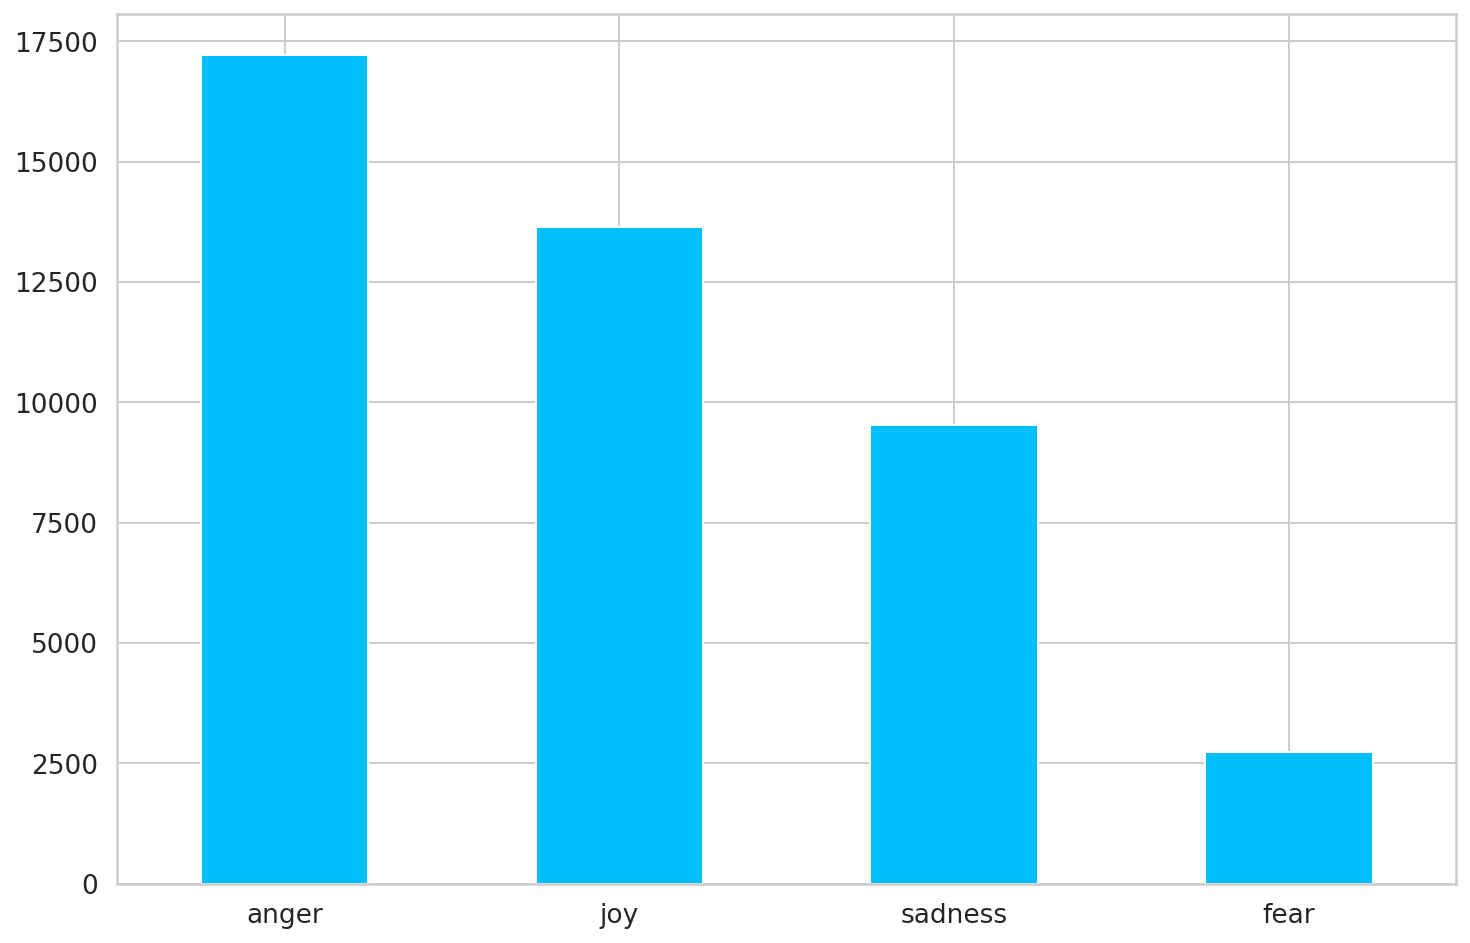

In [34]:
result.plot.bar(x='Emotion',y='frequency',rot=0)

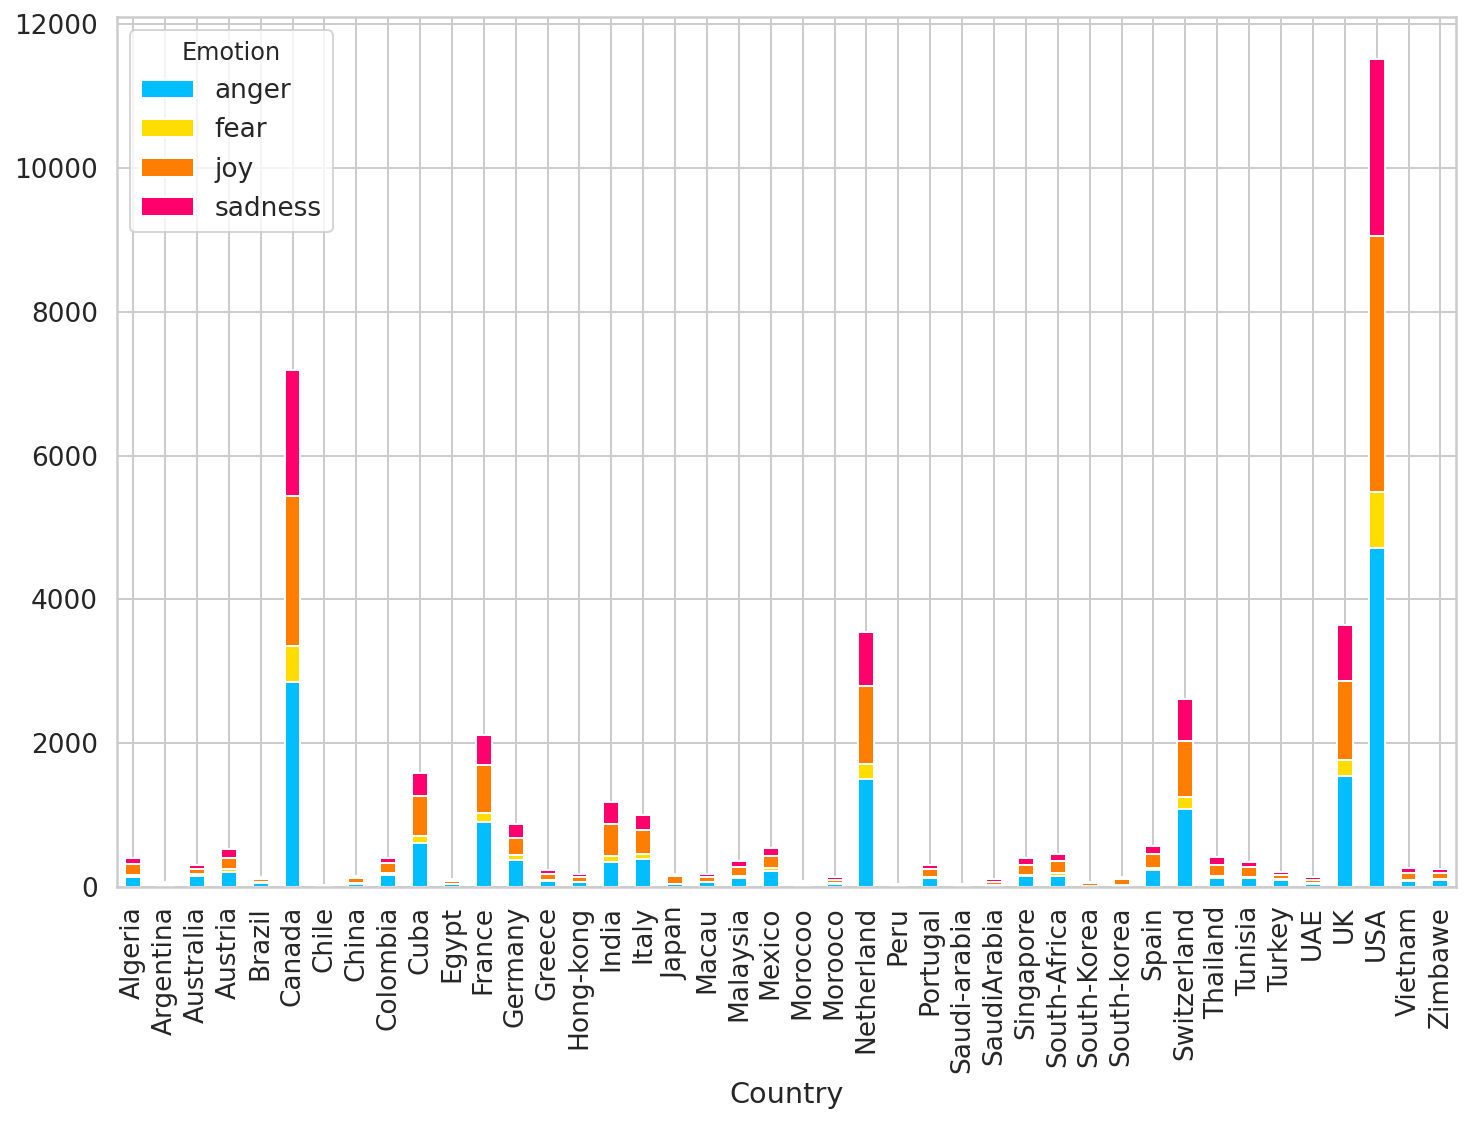

In [35]:
final_df.groupby(['Country', 'Emotion']).size().unstack().plot(kind='bar', stacked=True)

In [36]:
final_df.sort_values("Emotion", axis = 0, ascending = True,inplace = True, na_position ='last')
final_df.head()

,Unnamed: 0,Country,Tweet,Emotion
0,0,Brazil,un airbnb lejos con piscina y BBQ 🔥,anger
22833,22833,Netherland,News: Airbnb support firms want to offer credi...,anger
22830,22830,Netherland,@VanessaSBerlin if there's any way to raise it...,anger
22828,22828,Netherland,#ImpactSummit20 cases studies and thought lead...,anger
22827,22827,Netherland,@sargentcidered @Airbnb My step mother does in...,anger


In [0]:
anger_df=final_df[final_df.Emotion == 'anger']
sad_df=final_df[final_df.Emotion == 'sadness']
fear_df=final_df[final_df.Emotion == 'fear']
joy_df=final_df[final_df.Emotion == 'joy']

In [0]:
anger_df=anger_df.drop(['Unnamed: 0','Country'],axis=1)
sad_df=sad_df.drop(['Unnamed: 0','Country'],axis=1)
fear_df=fear_df.drop(['Unnamed: 0','Country'],axis=1)
joy_df=joy_df.drop(['Unnamed: 0','Country'],axis=1)


In [39]:
!pip install wordcloud
!pip install nltk

In [40]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
from collections import Counter
import numpy as np

sad_ctr=Counter()
fear_ctr=Counter()
angry_ctr=Counter()
joy_ctr=Counter()

In [0]:
def enumerate(ctr,df):
  # ctr=Counter()
  for e in df['Tweet']:
    for i in str(e).split(' '):
      ctr[i]+=1
  ctr['Airbnb']=0

In [0]:
enumerate(sad_ctr,sad_df)
enumerate(fear_ctr,fear_df)
enumerate(angry_ctr,anger_df)
enumerate(joy_ctr,joy_df)
# joy_ctr.most_common()
# fear_ctr.most_common()[200:300]

##word cloud

In [0]:
def join(lis):
  s=''
  for e in lis:
    s+=' {}'.format(str(e))
  return s

In [0]:
def stop(text):

  text_tokens = word_tokenize(text)

  tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]

  return join(tokens_without_sw)

In [0]:
def sent(ctr):
  s=''
  for e in ctr.most_common()[50:300]:
    s+=' {}'.format(str(e[0]))
  return stop(s)

In [0]:
sad_words=sent(sad_ctr)
fear_words=sent(fear_ctr)
joy_words=sent(joy_ctr)
anger_words=sent(angry_ctr)

In [0]:
def create_Cloud(s,name):
  stopwords = set(STOPWORDS)
  wc=WordCloud(width=1000,height=1000,background_color='white', stopwords=stopwords,min_font_size=10).generate(str(s))
  wc.to_file(name+'.png')

In [49]:
create_Cloud(sad_words,'sad')
create_Cloud(fear_words,'fear')
create_Cloud(anger_words,'anger')
create_Cloud(joy_words,'joy')



NameError: ignored

In [0]:
from scipy.stats import gaussian_kde
data = [1.5]*7 + [2.5]*2 + [3.5]*8 + [4.5]*3 + [5.5]*1 + [6.5]*8
density = gaussian_kde(data)
xs = np.linspace(0,8,100)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs))
plt.show()